<a href="https://colab.research.google.com/github/dineshssdn-867/2018.fossasia.org/blob/master/Auto_Feature_Extraction/CNN1D_%2B_LSTM_GRU_on_DEAP_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/forrestbao/pyeeg.git

Cloning into 'pyeeg'...
remote: Enumerating objects: 210, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 210 (delta 0), reused 0 (delta 0), pack-reused 207
Receiving objects: 100% (210/210), 119.45 KiB | 2.25 MiB/s, done.
Resolving deltas: 100% (95/95), done.


In [2]:
import numpy as np
import pickle as pickle
import pandas as pd
import math
import seaborn as sns

import matplotlib.pyplot as plt

import pyeeg as pe
import pywt

from sklearn import svm
from sklearn.preprocessing import normalize

import os
import time

In [3]:
import tensorflow as tf
import keras

from tensorflow.keras.utils import to_categorical 

from keras.models import Sequential
from keras.models import load_model

from keras.layers import Conv1D, MaxPooling1D
from keras.layers import BatchNormalization, Activation, Dropout, Flatten, Dense

from keras.layers import Bidirectional, TimeDistributed
from keras.layers import LSTM, GRU, SimpleRNN

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.regularizers import l2

from sklearn.metrics import confusion_matrix, classification_report

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Datasets Preparation

## Data Preprocessing

### Epoching + Label Mapping

In [5]:
def label_mapping(valence, arousal):
    # HVHA, HVLA, LVHA, and LVLA
    
    if (valence > 5 and arousal > 5):
        label = 0 #'HVHA'
    elif (valence > 5 and arousal <= 5):
        label = 1 #'HVLA'
    elif (valence <= 5 and arousal > 5):
        label = 2 #'LVHA'
    elif (valence <= 5 and arousal <= 5):
        label = 3 #'LVLA'
    
    return label

In [6]:
def map_label(label):
    new_label = label_mapping(label[0], label[1]) 
    return new_label

In [7]:
chan = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
print(chan)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]


In [8]:
channel = [1,2,3,4,7,11,13,17,19,20,21,25,29,31]
channel_test = [0, 16] # Fp1, Fp2

window_size = 256 #Averaging band power of 2 sec
step_size = 256 #Each 1 sec update once
subject_list = [
    '01','02','03','04','05','06','07','08','09','10'
    ,'11','12','13','14','15','16','17','18','19','20'
    ,'21','22','23','24','25','26','27','28','29','30'
    ,'31','32'
]

subject_train = [
    '01','02','03','04','05','06','07','08','09','10'
    ,'11','12','13','14','15','16','17','18','19','20'
    ,'21','22','23','24','25'
]

subject_val = ['26','27','28','29','30']
subject_test = ['31','32']

In [9]:
def epoching (sub, channel, window_size, step_size):
    
    signal = []
    with open("/content/drive/MyDrive/Akhand Sir UGRP/Main Data/s" + sub + '.dat', 'rb') as file:

        subject = pickle.load(file, encoding='latin1') #resolve the python 2 data problem by encoding : latin1

        for i in range (0,40):
            # loop over 0-39 trials
            data = subject["data"][i]
            labels = subject["labels"][i]
            labels = np.array(map_label(labels))
            start = 0;

            while start + window_size <= data.shape[1]:
                array = []
                for j in channel:
                    X = data[j][start : start + window_size] #Slice raw data over 2 sec, at interval of 1 sec
                    array.append(np.array(X))
                    array.append(np.array(labels))
                    signal.append(np.array(array))
  
                start = start + step_size
                
        signal = np.array(signal)
        np.save('/content/drive/MyDrive/Akhand Sir UGRP/Pre-processed Data/s' + sub, signal, allow_pickle=True, fix_imports=True)

In [10]:
for subjects in subject_list:
    epoching (subjects, channel, window_size, step_size)
    print(subjects)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


01
02
03
04
05
06
07
08
09
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32


In [11]:
with open('/content/drive/MyDrive/Akhand Sir UGRP/Pre-processed Data/s02' + '.npy', 'rb') as file:
    sub = np.load(file,allow_pickle=True)

In [12]:
print(sub.shape)
print(sub[0].shape)
print(sub[0][0].shape)
print(sub[0][1].shape)

(17360,)
(2,)
(256,)
()


# Data Preparation

## Combine Data

In [13]:
data = []
label = []

for subjects in subject_list:

    with open('/content/drive/MyDrive/Akhand Sir UGRP/Pre-processed Data/s' + subjects + '.npy', 'rb') as file:
        sub = np.load(file,allow_pickle=True)
        for i in range (0,sub.shape[0]):
            data.append(sub[i][0])
            label.append(sub[i][1])

np.save('/content/drive/MyDrive/Akhand Sir UGRP/Data for traning and testing/', np.array(data), allow_pickle=True, fix_imports=True)
np.save('/content/drive/MyDrive/Akhand Sir UGRP/Labels/', np.array(label), allow_pickle=True, fix_imports=True)
print("Training datasets:", np.array(data).shape, np.array(label).shape)

Training datasets: (555520, 256) (555520,)


In [14]:
unique, counts = np.unique(label, return_counts=True)
label_dist = dict(zip(unique, counts))
print(label_dist)

{0: 190526, 1: 116746, 2: 129332, 3: 118916}


In [15]:
with open('/content/drive/MyDrive/Akhand Sir UGRP/Data for traning and testing/data.npy', 'rb') as fileTrain:
    data  = np.load(fileTrain)
    
with open('/content/drive/MyDrive/Akhand Sir UGRP/Labels/labels.npy', 'rb') as fileTrainL:
    label  = np.load(fileTrainL)

## Train Val Test Split

In [16]:
print(data.shape)
print(label.shape)

(555520, 256)
(555520,)


In [17]:
x_train, x, y_train, y = train_test_split(data, label, test_size=0.3, random_state=42)

In [18]:
x_val, x_test, y_val, y_test = train_test_split(x, y, test_size=0.5, random_state=42)

In [19]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(388864, 256)
(388864,)
(83328, 256)
(83328,)
(83328, 256)
(83328,)


In [20]:
unique, counts = np.unique(y_train, return_counts=True)
label_dist = dict(zip(unique, counts))
print(label_dist)
unique, counts = np.unique(y_val, return_counts=True)
label_dist = dict(zip(unique, counts))
print(label_dist)
unique, counts = np.unique(y_test, return_counts=True)
label_dist = dict(zip(unique, counts))
print(label_dist)

{0: 133342, 1: 81494, 2: 90630, 3: 83398}
{0: 28389, 1: 17818, 2: 19365, 3: 17756}
{0: 28795, 1: 17434, 2: 19337, 3: 17762}


In [21]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

# Save and Load Datasets

In [ ]:
np.save('C:\\.Farhad\\.Telkom\\Emotion Recognition\\Datasets\\DREAMER\\x_train', np.array(x_train), allow_pickle=True, fix_imports=True)
np.save('C:\\.Farhad\\.Telkom\\Emotion Recognition\\Datasets\\DREAMER\\y_train', np.array(y_train), allow_pickle=True, fix_imports=True)
np.save('C:\\.Farhad\\.Telkom\\Emotion Recognition\\Datasets\\DREAMER\\x_val', np.array(x_val), allow_pickle=True, fix_imports=True)
np.save('C:\\.Farhad\\.Telkom\\Emotion Recognition\\Datasets\\DREAMER\\y_val', np.array(y_val), allow_pickle=True, fix_imports=True)
np.save('C:\\.Farhad\\.Telkom\\Emotion Recognition\\Datasets\\DREAMER\\x_test', np.array(x_test), allow_pickle=True, fix_imports=True)
np.save('C:\\.Farhad\\.Telkom\\Emotion Recognition\\Datasets\\DREAMER\\y_test', np.array(y_test), allow_pickle=True, fix_imports=True)

In [ ]:
with open('C:\\.Farhad\\.Telkom\\Emotion Recognition\\Datasets\\DEAP\\all\\x_train.npy', 'rb') as file:
    x_train = np.load(file, allow_pickle=True)
with open('C:\\.Farhad\\.Telkom\\Emotion Recognition\\Datasets\\DEAP\\all\\y_train.npy', 'rb') as file:
    y_train = np.load(file, allow_pickle=True)
with open('C:\\.Farhad\\.Telkom\\Emotion Recognition\\Datasets\\DEAP\\all\\x_val.npy', 'rb') as file:
    x_val = np.load(file, allow_pickle=True)
with open('C:\\.Farhad\\.Telkom\\Emotion Recognition\\Datasets\\DEAP\\all\\y_val.npy', 'rb') as file:
    y_val = np.load(file, allow_pickle=True)
with open('C:\\.Farhad\\.Telkom\\Emotion Recognition\\Datasets\\DEAP\\all\\x_test.npy', 'rb') as file:
    x_test = np.load(file, allow_pickle=True)
with open('C:\\.Farhad\\.Telkom\\Emotion Recognition\\Datasets\\DEAP\\all\\y_test.npy', 'rb') as file:
    y_test = np.load(file, allow_pickle=True)

# Scaling and Normalization

In [22]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(388864, 256)
(388864, 4)
(83328, 256)
(83328, 4)
(83328, 256)
(83328, 4)


In [23]:
scaler = StandardScaler()

In [24]:
# 4 Normalization -> Standardization 
x_train = scaler.fit_transform(normalize(x_train))
x_val = scaler.fit_transform(normalize(x_val))
x_test = scaler.fit_transform(normalize(x_test))

## Reshaping

In [25]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1], 1)
x_val = x_val.reshape(x_val.shape[0],x_test.shape[1],1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [26]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(388864, 256, 1)
(83328, 256, 1)
(83328, 256, 1)
(388864, 4)
(83328, 4)
(83328, 4)


# Train Data

In [27]:
input_shape=(x_train.shape[1],x_train.shape[2])
print(input_shape)

(256, 1)


In [31]:
batch_size = 16
num_classes = 4
epochs = 20

## Model 1: CONV1D

In [31]:
model_1 = Sequential()

model_1.add(Conv1D(128, 3, activation='relu', input_shape=input_shape))
model_1.add(MaxPooling1D(pool_size=2))
model_1.add(Dropout(0.2))

model_1.add(Conv1D(128, 3,  activation='relu'))
model_1.add(MaxPooling1D(pool_size=2))
model_1.add(Dropout(0.2))

model_1.add(Flatten())

model_1.add(Dense(units = 128, activation='relu'))
model_1.add(Dropout(0.2))

model_1.add(Dense(units = num_classes))
model_1.add(Activation('softmax'))

model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 254, 128)          512       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 127, 128)         0         
 1D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 127, 128)          0         
                                                                 
 conv1d_3 (Conv1D)           (None, 125, 128)          49280     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 62, 128)          0         
 1D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 62, 128)          

In [32]:
model_1.compile(
    optimizer ="adam",
    loss = 'categorical_crossentropy',
    metrics=["accuracy"]
)

In [33]:
history_1 = model_1.fit(
    x_train, 
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    validation_data=(x_val, y_val),
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True
        )
    ]
)

Epoch 1/20
20832/20832 [==============================] - 149s 7ms/step - loss: 1.3251 - accuracy: 0.3707 - val_loss: 1.1755 - val_accuracy: 0.4986
Epoch 2/20
20832/20832 [==============================] - 158s 8ms/step - loss: 1.1052 - accuracy: 0.5175 - val_loss: 0.8419 - val_accuracy: 0.7054
Epoch 3/20
20832/20832 [==============================] - 157s 8ms/step - loss: 0.9302 - accuracy: 0.6104 - val_loss: 0.6598 - val_accuracy: 0.7960
Epoch 4/20
20832/20832 [==============================] - 159s 8ms/step - loss: 0.8345 - accuracy: 0.6588 - val_loss: 0.5406 - val_accuracy: 0.8499
Epoch 5/20
20832/20832 [==============================] - 159s 8ms/step - loss: 0.7718 - accuracy: 0.6892 - val_loss: 0.4710 - val_accuracy: 0.8843
Epoch 6/20
20832/20832 [==============================] - 158s 8ms/step - loss: 0.7159 - accuracy: 0.7144 - val_loss: 0.4002 - val_accuracy: 0.9071
Epoch 7/20
20832/20832 [==============================] - 161s 8ms/step - loss: 0.6720 - accuracy: 0.7368 - val_

In [ ]:
score_1 = model_1.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score_1[0])
print('Test accuracy:', score_1[1])

3472/3472 [==============================] - 19s 5ms/step - loss: 0.0338 - accuracy: 0.9992
Test loss: 0.03377590328454971
Test accuracy: 0.9992259740829468


### Save Model

In [ ]:
model_1.save('/content/drive/MyDrive/Akhand Sir UGRP/Models/conv1d_model.h5')
np.save('/content/drive/MyDrive/Akhand Sir UGRP/Models/conv1d_model.npy', history_1.history)

# Model 2: GRU

In [32]:
batch_size=256

In [33]:
model_2 = Sequential()

model_2.add(Conv1D(128, 3, activation='relu', input_shape=input_shape))
model_2.add(MaxPooling1D(pool_size=2))
model_2.add(Dropout(0.2))

model_2.add(GRU(units = 256, return_sequences=True))  
model_2.add(Dropout(0.2))

model_2.add(GRU(units = 32))
model_2.add(Dropout(0.2))

model_2.add(Flatten())

model_2.add(Dense(units = 128, activation='relu'))
model_2.add(Dropout(0.2))

model_2.add(Dense(units = num_classes))
model_2.add(Activation('softmax'))

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 254, 128)          512       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 127, 128)         0         
 1D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 127, 128)          0         
                                                                 
 gru_2 (GRU)                 (None, 127, 256)          296448    
                                                                 
 dropout_5 (Dropout)         (None, 127, 256)          0         
                                                                 
 gru_3 (GRU)                 (None, 32)                27840     
                                                      

In [37]:
model_2.load_weights('/content/drive/MyDrive/Akhand Sir UGRP/Models/gru_model.h5')

In [38]:
model_2.compile(
    optimizer ="adam",
    loss = 'categorical_crossentropy',
    metrics=["accuracy"]
)

In [40]:
history_2 = model_2.fit(
    x_train, 
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    validation_data=(x_val, y_val),
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True
        )
    ]
)

Epoch 1/20
1519/1519 [==============================] - 189s 114ms/step - loss: 0.3473 - accuracy: 0.8657 - val_loss: 0.2022 - val_accuracy: 0.9241
Epoch 2/20
1519/1519 [==============================] - 171s 113ms/step - loss: 0.3213 - accuracy: 0.8768 - val_loss: 0.1964 - val_accuracy: 0.9250
Epoch 3/20
1519/1519 [==============================] - 171s 113ms/step - loss: 0.3005 - accuracy: 0.8861 - val_loss: 0.1755 - val_accuracy: 0.9338
Epoch 4/20
1519/1519 [==============================] - 170s 112ms/step - loss: 0.2812 - accuracy: 0.8943 - val_loss: 0.1483 - val_accuracy: 0.9459
Epoch 5/20
1519/1519 [==============================] - 171s 112ms/step - loss: 0.2642 - accuracy: 0.9022 - val_loss: 0.1474 - val_accuracy: 0.9481
Epoch 6/20
1519/1519 [==============================] - 171s 113ms/step - loss: 0.2477 - accuracy: 0.9095 - val_loss: 0.1353 - val_accuracy: 0.9505
Epoch 7/20
1519/1519 [==============================] - 171s 113ms/step - loss: 0.2355 - accuracy: 0.9150 - val_

In [41]:
score_2 = model_2.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score_2[0])
print('Test accuracy:', score_2[1])

2604/2604 [==============================] - 67s 25ms/step - loss: 0.0432 - accuracy: 0.9881
Test loss: 0.04315100982785225
Test accuracy: 0.9880832433700562


### Save Model

In [42]:
model_2.save('/content/drive/MyDrive/Akhand Sir UGRP/Models/gru_model.h5')
np.save('/content/drive/MyDrive/Akhand Sir UGRP/Models/gru_model.npy', history_2.history)

## Model 3: LSTM

In [ ]:
factor = 0.01
rate = 0.2

In [ ]:
model_3 = Sequential()

model_3.add(Conv1D(128, 3, activation='relu', input_shape=input_shape))
model_3.add(MaxPooling1D(pool_size=2))
model_3.add(Dropout(rate))

model_3.add(Conv1D(128, 3, activation='relu'))
model_3.add(MaxPooling1D(pool_size=2))
model_3.add(Dropout(rate))

model_3.add(LSTM(units = 256, return_sequences=True))  
model_3.add(Dropout(rate))

model_3.add(LSTM(units = 128, return_sequences=True))  
model_3.add(Dropout(rate))

model_3.add(LSTM(units = 64, return_sequences=True))  
model_3.add(Dropout(rate))

model_3.add(LSTM(units = 32))
model_3.add(Dropout(rate))

model_3.add(Flatten())

model_3.add(Dense(units = 128, activation='relu'))
model_3.add(Dropout(rate))

model_3.add(Dense(units = num_classes))
model_3.add(Activation('softmax'))

model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 254, 128)          512       
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 127, 128)         0         
 1D)                                                             
                                                                 
 dropout_10 (Dropout)        (None, 127, 128)          0         
                                                                 
 conv1d_5 (Conv1D)           (None, 125, 128)          49280     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 62, 128)          0         
 1D)                                                             
                                                                 
 dropout_11 (Dropout)        (None, 62, 128)          

In [ ]:
model_3.compile(
    optimizer ="adam",
    loss = 'categorical_crossentropy',
    metrics=["accuracy"]
)

In [ ]:
history_3 = model_3.fit(
    x_train, 
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    validation_data=(x_val, y_val),
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True
        )
    ]
)

Epoch 1/20
1302/1302 [==============================] - 75s 54ms/step - loss: 1.3653 - accuracy: 0.3425 - val_loss: 1.3650 - val_accuracy: 0.3428
Epoch 2/20
1302/1302 [==============================] - 69s 53ms/step - loss: 1.3644 - accuracy: 0.3430 - val_loss: 1.3645 - val_accuracy: 0.3428
Epoch 3/20
1302/1302 [==============================] - 66s 51ms/step - loss: 1.3643 - accuracy: 0.3430 - val_loss: 1.3643 - val_accuracy: 0.3428
Epoch 4/20
1302/1302 [==============================] - 66s 50ms/step - loss: 1.3643 - accuracy: 0.3430 - val_loss: 1.3643 - val_accuracy: 0.3428
Epoch 5/20
1302/1302 [==============================] - 66s 50ms/step - loss: 1.3642 - accuracy: 0.3430 - val_loss: 1.3643 - val_accuracy: 0.3428
Epoch 6/20
1302/1302 [==============================] - 69s 53ms/step - loss: 1.3642 - accuracy: 0.3430 - val_loss: 1.3644 - val_accuracy: 0.3428
Epoch 7/20
1302/1302 [==============================] - 66s 51ms/step - loss: 1.3642 - accuracy: 0.3430 - val_loss: 1.3644 -

In [ ]:
score_3 = model_3.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score_3[0])
print('Test accuracy:', score_3[1])

3472/3472 [==============================] - 30s 8ms/step - loss: 1.3641 - accuracy: 0.3431
Test loss: 1.3640587329864502
Test accuracy: 0.343146950006485


### Save Model

In [ ]:
model_3.save('/content/drive/MyDrive/Akhand Sir UGRP/Models/lstm_model.h5')
np.save('/content/drive/MyDrive/Akhand Sir UGRP/Models/lstm_model.npy', history_3.history)

# Load Model, Results, and Model Analysis

## CONV1D Model

In [ ]:
directory = '/content/drive/MyDrive/Akhand Sir UGRP/Models/conv1d_model.h5'
lstm_model = load_model(directory)
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 254, 128)          512       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 127, 128)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 128)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 125, 128)          49280     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 62, 128)          0         
 1D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 62, 128)           0

In [ ]:
lstm_history = np.load('/content/drive/MyDrive/Akhand Sir UGRP/Models/conv1d_model.npy',allow_pickle='TRUE').item()
lstm_history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
print("Training Accuracy: ", np.max(lstm_history['accuracy']))
print("Training Loss: ", np.min(lstm_history['loss']))
print("Validation Accuracy: ", np.max(lstm_history['val_accuracy']))
print("Validation Loss: ", np.min(lstm_history['val_loss']))

Training Accuracy:  0.897015392780304
Training Loss:  0.28046274185180664
Validation Accuracy:  0.9992889761924744
Validation Loss:  0.033628929406404495


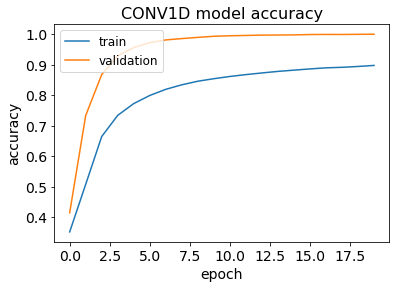

In [ ]:
# summarize history for accuracy
plt.plot(lstm_history['accuracy'])
plt.plot(lstm_history['val_accuracy'])
plt.title('CONV1D model accuracy', fontsize=16)
plt.ylabel('accuracy', fontsize=14)
plt.xlabel('epoch', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['train', 'validation'], loc='upper left', fontsize=12)
plt.show()

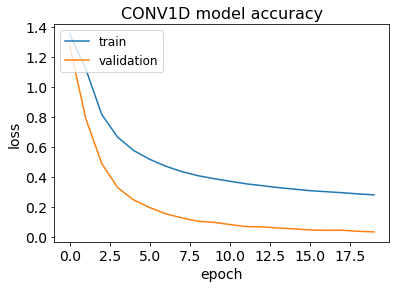

In [ ]:
# summarize history for loss
plt.plot(lstm_history['loss'])
plt.plot(lstm_history['val_loss'])
plt.title('CONV1D model accuracy', fontsize=16)
plt.ylabel('loss', fontsize=14)
plt.xlabel('epoch', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['train', 'validation'], loc='upper left', fontsize=12)
plt.show()

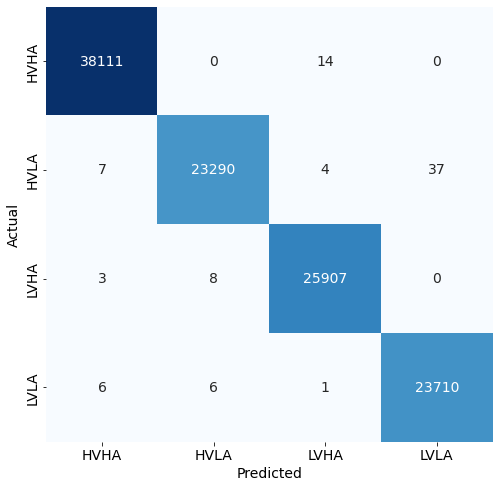

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     38125
           1       1.00      1.00      1.00     23338
           2       1.00      1.00      1.00     25918
           3       1.00      1.00      1.00     23723

    accuracy                           1.00    111104
   macro avg       1.00      1.00      1.00    111104
weighted avg       1.00      1.00      1.00    111104



In [ ]:
class_names = ['HVHA', 'HVLA', 'LVHA', 'LVLA']

y_pred = lstm_model.predict(x_test)

y_predict = []

for i in range(len(y_pred)):
    y_predict.append(np.argmax(y_pred[i]))

y_predict = np.array(y_predict)
yt_test = np.argmax(y_test, axis=1)

cm = confusion_matrix(yt_test, y_predict)
clr = classification_report(yt_test, y_predict)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues', annot_kws={"size":14})
plt.xticks(np.arange(4) + 0.5, class_names, fontsize=14)
plt.yticks(np.arange(4) + 0.5, class_names, fontsize=14)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("Actual", fontsize=14)
# plt.title("Confusion Matrix for LSTM Model")
plt.show()

print("Classification Report:\n----------------------\n", clr)

## GRU Model

In [43]:
directory = '/content/drive/MyDrive/Akhand Sir UGRP/Models/gru_model.h5'
gru_model = load_model(directory)
gru_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 254, 128)          512       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 127, 128)         0         
 1D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 127, 128)          0         
                                                                 
 gru_2 (GRU)                 (None, 127, 256)          296448    
                                                                 
 dropout_5 (Dropout)         (None, 127, 256)          0         
                                                                 
 gru_3 (GRU)                 (None, 32)                27840     
                                                      

In [44]:
gru_history = np.load('/content/drive/MyDrive/Akhand Sir UGRP/Models/gru_model.npy',allow_pickle='TRUE').item()
gru_history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [45]:
print("Training Accuracy: ", np.max(gru_history['accuracy']))
print("Training Loss: ", np.min(gru_history['loss']))
print("Validation Accuracy: ", np.max(gru_history['val_accuracy']))
print("Validation Loss: ", np.min(gru_history['val_loss']))

Training Accuracy:  0.9514766335487366
Training Loss:  0.14246921241283417
Validation Accuracy:  0.9880592226982117
Validation Loss:  0.04250926896929741


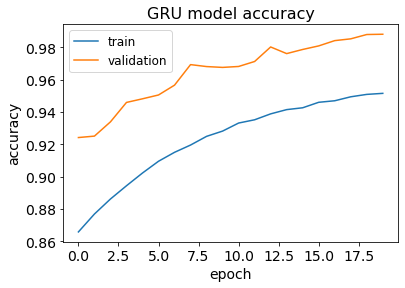

In [46]:
# summarize history for accuracy
plt.plot(gru_history['accuracy'])
plt.plot(gru_history['val_accuracy'])
plt.title('GRU model accuracy', fontsize=16)
plt.ylabel('accuracy', fontsize=14)
plt.xlabel('epoch', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['train', 'validation'], loc='upper left', fontsize=12)
plt.show()

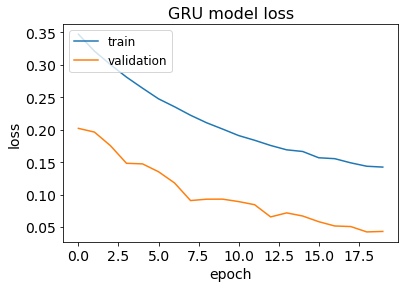

In [47]:
# summarize history for loss
plt.plot(gru_history['loss'])
plt.plot(gru_history['val_loss'])
plt.title('GRU model loss', fontsize=16)
plt.ylabel('loss', fontsize=14)
plt.xlabel('epoch', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['train', 'validation'], loc='upper left', fontsize=12)
plt.show()

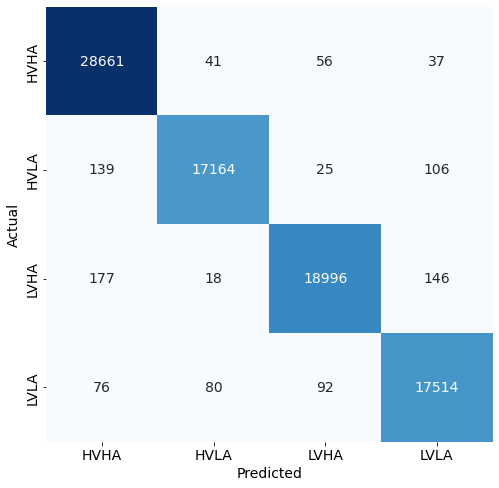

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     28795
           1       0.99      0.98      0.99     17434
           2       0.99      0.98      0.99     19337
           3       0.98      0.99      0.98     17762

    accuracy                           0.99     83328
   macro avg       0.99      0.99      0.99     83328
weighted avg       0.99      0.99      0.99     83328



In [48]:
class_names = ['HVHA', 'HVLA', 'LVHA', 'LVLA']

y_pred = gru_model.predict(x_test)

y_predict = []

for i in range(len(y_pred)):
    y_predict.append(np.argmax(y_pred[i]))

y_predict = np.array(y_predict)
yt_test = np.argmax(y_test, axis=1)

cm = confusion_matrix(yt_test, y_predict)
clr = classification_report(yt_test, y_predict)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues', annot_kws={"size":14})
plt.xticks(np.arange(4) + 0.5, class_names, fontsize=14)
plt.yticks(np.arange(4) + 0.5, class_names, fontsize=14)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("Actual", fontsize=14)
# plt.title("Confusion Matrix for GRU Model")
plt.show()

print("Classification Report:\n----------------------\n", clr)

## LSTM Model

In [ ]:
directory = '/content/drive/MyDrive/Akhand Sir UGRP/Models/lstm_model.h5'
lstm_model = load_model(directory)
lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 254, 128)          512       
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 127, 128)         0         
 1D)                                                             
                                                                 
 dropout_10 (Dropout)        (None, 127, 128)          0         
                                                                 
 conv1d_5 (Conv1D)           (None, 125, 128)          49280     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 62, 128)          0         
 1D)                                                             
                                                                 
 dropout_11 (Dropout)        (None, 62, 128)          

In [ ]:
lstm_history = np.load('/content/drive/MyDrive/Akhand Sir UGRP/Models/lstm_model.npy',allow_pickle='TRUE').item()
lstm_history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
print("Training Accuracy: ", np.max(lstm_history['accuracy']))
print("Training Loss: ", np.min(lstm_history['loss']))
print("Validation Accuracy: ", np.max(lstm_history['val_accuracy']))
print("Validation Loss: ", np.min(lstm_history['val_loss']))

Training Accuracy:  0.34295496344566345
Training Loss:  1.3641555309295654
Validation Accuracy:  0.34283193945884705
Validation Loss:  1.3642781972885132


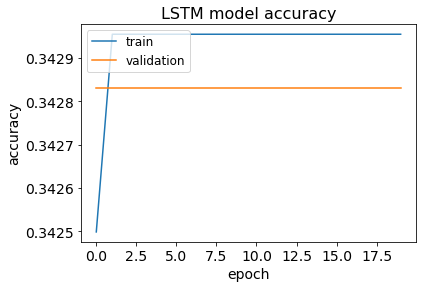

In [ ]:
# summarize history for accuracy
plt.plot(lstm_history['accuracy'])
plt.plot(lstm_history['val_accuracy'])
plt.title('LSTM model accuracy', fontsize=16)
plt.ylabel('accuracy', fontsize=14)
plt.xlabel('epoch', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['train', 'validation'], loc='upper left', fontsize=12)
plt.show()

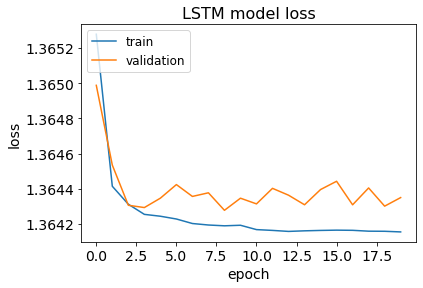

In [ ]:
# summarize history for loss
plt.plot(lstm_history['loss'])
plt.plot(lstm_history['val_loss'])
plt.title('LSTM model loss', fontsize=16)
plt.ylabel('loss', fontsize=14)
plt.xlabel('epoch', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['train', 'validation'], loc='upper left', fontsize=12)
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


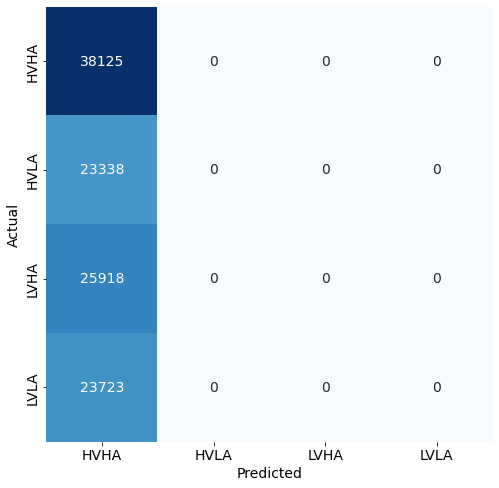

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.34      1.00      0.51     38125
           1       0.00      0.00      0.00     23338
           2       0.00      0.00      0.00     25918
           3       0.00      0.00      0.00     23723

    accuracy                           0.34    111104
   macro avg       0.09      0.25      0.13    111104
weighted avg       0.12      0.34      0.18    111104



In [ ]:
class_names = ['HVHA', 'HVLA', 'LVHA', 'LVLA']

y_pred = lstm_model.predict(x_test)

y_predict = []

for i in range(len(y_pred)):
    y_predict.append(np.argmax(y_pred[i]))

y_predict = np.array(y_predict)
yt_test = np.argmax(y_test, axis=1)

cm = confusion_matrix(yt_test, y_predict)
clr = classification_report(yt_test, y_predict)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues', annot_kws={"size":14})
plt.xticks(np.arange(4) + 0.5, class_names, fontsize=14)
plt.yticks(np.arange(4) + 0.5, class_names, fontsize=14)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("Actual", fontsize=14)
# plt.title("Confusion Matrix for LSTM Model")
plt.show()

print("Classification Report:\n----------------------\n", clr)